In [ ]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: True


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
from transformers import (
    GPT2Tokenizer, GPT2LMHeadModel,
    TrainingArguments, Trainer
)

df = pd.read_csv("ppd_data.csv", encoding='latin1')
texts = df["text"].values.astype(str).tolist()
labels = df["label"].values

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.15, stratify=labels, random_state=42
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1765, stratify=train_labels, random_state=42  # 0.1765≈15%/85%
)

print(f"""Dataset：
Train: {len(train_texts)}
val: {len(val_texts)}
test: {len(test_texts)}""")

def compute_metrics(preds, true_labels):
    return {
        "accuracy": accuracy_score(true_labels, preds),
        "f1_weighted": f1_score(true_labels, preds, average="weighted"),
        "f1_macro": f1_score(true_labels, preds, average="macro")
    }

In [ ]:
# ===================== PsychGPT (GPT-2) =====================
gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

label_map = {0: "asymptomatic", 1: "moderate", 2: "severe"}

def format_gpt_data(texts, labels):
    return [f"Text: {t}\nLabel: {label_map[l]}</s>" for t, l in zip(texts, labels)]

gpt_train = format_gpt_data(train_texts, train_labels)
gpt_val = format_gpt_data(val_texts, val_labels)

class GPT2ForClassification(GPT2LMHeadModel):
    def __init__(self, config):
        super().__init__(config)
        self.score = torch.nn.Linear(config.n_embd, 3)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = super().forward(
            input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        hidden_states = outputs.hidden_states[-1][:, -1, :]  # 取最后一个token的隐藏状态
        logits = self.score(hidden_states)
        loss = None
        if labels is not None:
            loss = torch.nn.CrossEntropyLoss()(logits, labels)
        return {"loss": loss, "logits": logits}

gpt_model = GPT2ForClassification.from_pretrained("gpt2")

max_length = 512
def encode_gpt(texts):
    return gpt_tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )

gpt_train_encodings = encode_gpt(gpt_train)
gpt_val_encodings = encode_gpt(gpt_val)



tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.bias', 'score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset

class GPTDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])  # Add labels
        return item

# Prepare datasets
train_dataset = GPTDataset(gpt_train_encodings, train_labels)
val_dataset = GPTDataset(gpt_val_encodings, val_labels)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

gpt_model.to(device)

# Define Trainer arguments
gpt_args = TrainingArguments(
    output_dir="./gpt_output",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    fp16=True,  # Enable mixed-precision training (if supported by GPU)
    logging_steps=50,
    save_steps=500,
    eval_strategy="steps",  # Evaluate every 'logging_steps' steps
)

# Initialize Trainer
gpt_trainer = Trainer(
    model=gpt_model,
    args=gpt_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Start training
print("\nTraining PsychGPT...")
gpt_trainer.train()



Using device: cuda

Training PsychGPT...


Step,Training Loss,Validation Loss
50,2.168200,0.466711
100,0.281000,0.317142
150,0.231400,0.273703
200,0.190600,0.406501
250,0.250400,0.275596
300,0.094600,0.266083
350,0.100300,0.293744
400,0.065900,0.694648
450,0.199200,0.486916
500,0.129400,0.308771


TrainOutput(global_step=840, training_loss=0.23224108832932655, metrics={'train_runtime': 230.7839, 'train_samples_per_second': 14.494, 'train_steps_per_second': 3.64, 'total_flos': 874045553402880.0, 'train_loss': 0.23224108832932655, 'epoch': 5.0})

In [ ]:
# ===================== Evaluation =====================
from sklearn.metrics import classification_report
# Function to predict and get labels for evaluation
def predict_and_get_labels(trainer, dataset):
    # Get predictions
    predictions = trainer.predict(dataset)
    # Get predicted labels (taking the argmax of logits)
    pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1)
    true_labels = torch.tensor(predictions.label_ids)
    return pred_labels, true_labels

# Get predictions and true labels from the validation dataset
pred_labels, true_labels = predict_and_get_labels(gpt_trainer, val_dataset)

# Generate and print classification report
report = classification_report(true_labels.numpy(), pred_labels.numpy(), target_names=label_map.values())
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

asymptomatic       0.92      0.91      0.91        76
    moderate       0.85      0.91      0.88        45
      severe       0.76      0.70      0.73        23

    accuracy                           0.88       144
   macro avg       0.85      0.84      0.84       144
weighted avg       0.87      0.88      0.87       144



###XLNet模型的训练和评估

训练集: 997 样本 (70.0%)
验证集: 214 样本 (15.0%)
测试集: 214 样本 (15.0%)
类别权重: [0.94412879 1.59775641 0.76048818]


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

使用设备: cuda
Epoch 1/5
训练Loss: 1.0152
验证Loss: 0.7524
保存新的最佳模型
------------------------------------------------------------
Epoch 2/5
训练Loss: 0.6810
验证Loss: 0.5096
保存新的最佳模型
------------------------------------------------------------
Epoch 3/5
训练Loss: 0.4402
验证Loss: 0.9075
验证Loss未改善。耐心: 1/3
------------------------------------------------------------
Epoch 4/5
训练Loss: 0.2592
验证Loss: 0.8729
验证Loss未改善。耐心: 2/3
------------------------------------------------------------
Epoch 5/5
训练Loss: 0.1124
验证Loss: 1.0501
验证Loss未改善。耐心: 3/3
提前停止训练

测试集分类报告:
              precision    recall  f1-score   support

      轻度产后抑郁       0.74      0.71      0.72        76
      中度产后抑郁       0.43      0.67      0.53        45
      重度产后抑郁       0.90      0.70      0.79        93

    accuracy                           0.70       214
   macro avg       0.69      0.69      0.68       214
weighted avg       0.75      0.70      0.71       214



/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 36731 (\N{CJK UNIFIED IDEOGRAPH-8F7B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 25233 (\N{CJK UNIFIED IDEOGRAPH-6291}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 37057 (\N{CJK UNIFIED IDEOGRAPH-90C1}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from fon

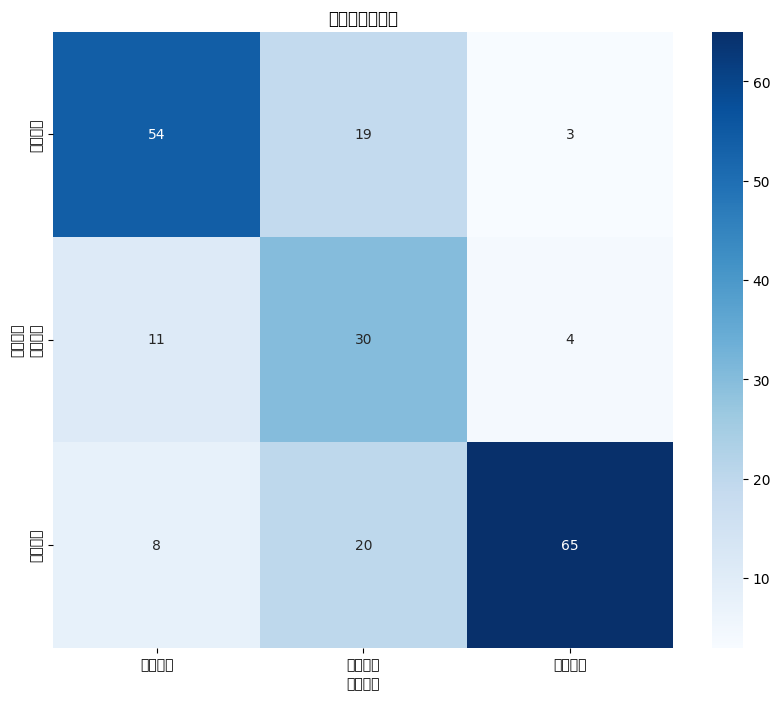

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch.optim import AdamW
from transformers import XLNetTokenizer, XLNetForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from transformers import XLNetConfig

# 加载数据
data = pd.read_csv('data.csv', encoding='latin1')

# 数据增强函数 - 针对重度抑郁样本
def augment_text(text):
    words = text.split()
    if len(words) > 10:
        # 随机删除词
        drop_percent = 0.1
        to_drop = np.random.choice([0, 1], size=len(words), p=[1-drop_percent, drop_percent])
        return ' '.join([w for i, w in enumerate(words) if to_drop[i] == 0])
    return text

# 对重度抑郁样本进行增强
augmented_texts = []
augmented_labels = []
for text, label in zip(data['text'].values, data['label'].values):
    if label == 2:  # 重度抑郁
        # 为每个重度样本创建3个增强版本
        for _ in range(3):
            augmented_texts.append(augment_text(text))
            augmented_labels.append(label)

# 合并原始和增强数据
augmented_df = pd.DataFrame({
    'text': np.concatenate([data['text'].values, augmented_texts]),
    'label': np.concatenate([data['label'].values, augmented_labels])
})

# 首先将数据分为训练集(70%)和临时集(30%)
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    augmented_df['text'].values, augmented_df['label'].values,
    test_size=0.3, random_state=40, stratify=augmented_df['label']
)

# 然后将临时测试集分为验证集(15%)和测试集(15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_temp, y_test_temp,
    test_size=0.5, random_state=40, stratify=y_test_temp
)

print(f"训练集: {len(X_train_temp)} 样本 ({len(X_train_temp)/len(augmented_df['text'])*100:.1f}%)")
print(f"验证集: {len(X_val)} 样本 ({len(X_val)/len(augmented_df['text'])*100:.1f}%)")
print(f"测试集: {len(X_test)} 样本 ({len(X_test)/len(augmented_df['text'])*100:.1f}%)")

# 计算类别权重
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_temp), y=y_train_temp)
print(f"类别权重: {class_weights}")

# 初始化tokenizer和模型
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# 创建自定义配置
config = XLNetConfig.from_pretrained('xlnet-base-cased')
config.hidden_dropout_prob = 0.2
config.attention_probs_dropout_prob = 0.2
config.num_labels = 3

# 使用自定义配置创建模型
model = XLNetForSequenceClassification.from_pretrained(
    'xlnet-base-cased',
    config=config
)

# 数据预处理
def tokenize_data(texts, labels, tokenizer, max_len=256):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

# 处理数据集
train_inputs, train_masks, train_labels = tokenize_data(X_train_temp, y_train_temp, tokenizer)
val_inputs, val_masks, val_labels = tokenize_data(X_val, y_val, tokenizer)
test_inputs, test_masks, test_labels = tokenize_data(X_test, y_test, tokenizer)

# 创建DataLoader
batch_size = 8  # 减小批次大小
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# 训练设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
model.to(device)

# 转换类别权重为张量并移至设备
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# 优化器设置
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8, weight_decay=0.01)
epochs = 5  # 增加训练轮次

# 设置学习率调度器
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps*0.1),
    num_training_steps=total_steps
)

# 训练循环
best_val_loss = float('inf')
patience = 3  # 增加耐心值
patience_counter = 0

for epoch in range(epochs):
    # 训练阶段
    model.train()
    total_train_loss = 0

    for batch in train_dataloader:
        optimizer.zero_grad()

        batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)
        outputs = model(
            input_ids=batch_inputs,
            attention_mask=batch_masks,
            labels=None  # 不直接计算损失
        )

        # 使用带权重的损失函数
        logits = outputs.logits
        loss = criterion(logits, batch_labels)

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # 验证阶段
    model.eval()
    total_val_loss = 0

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            outputs = model(
                input_ids=batch_inputs,
                attention_mask=batch_masks,
                labels=None
            )

            logits = outputs.logits
            loss = criterion(logits, batch_labels)

        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"训练Loss: {avg_train_loss:.4f}")
    print(f"验证Loss: {avg_val_loss:.4f}")

    # 提前停止逻辑
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # 保存最佳模型
        torch.save(model.state_dict(), 'best_xlnet_model_improved.pt')
        print("保存新的最佳模型")
    else:
        patience_counter += 1
        print(f"验证Loss未改善。耐心: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("提前停止训练")
        break

    print("-" * 60)

# 加载最佳模型进行测试
model.load_state_dict(torch.load('best_xlnet_model_improved.pt'))
model.eval()

# 在测试集上评估
predictions = []
true_labels = []
prediction_probs = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(
            input_ids=batch_inputs,
            attention_mask=batch_masks
        )

    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=1)
    pred = torch.argmax(logits, dim=1).cpu().numpy()

    predictions.extend(pred)
    true_labels.extend(batch_labels.cpu().numpy())
    prediction_probs.extend(probs.cpu().numpy())

# 打印分类报告
print("\n测试集分类报告:")
print(classification_report(true_labels, predictions, target_names=['轻度产后抑郁', '中度产后抑郁', '重度产后抑郁']))

# 混淆矩阵可视化
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['轻度抑郁', '中度抑郁', '重度抑郁'],
            yticklabels=['轻度抑郁', '中度抑郁', '重度抑郁'])
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title('测试集混淆矩阵')
plt.show()

# 保存预测概率
prediction_df = pd.DataFrame({
    'true_label': true_labels,
    'predicted_label': predictions,
    'prob_mild': [p[0] for p in prediction_probs],
    'prob_moderate': [p[1] for p in prediction_probs],
    'prob_severe': [p[2] for p in prediction_probs]
})
prediction_df.to_csv('xlnet_predictions.csv', index=False)

In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import XLNetTokenizer, XLNetForSequenceClassification

# 1. 加载保存的模型和分词器
def load_model(model_path, num_labels=3):
    # 加载分词器
    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

    # 加载模型配置和权重
    model = XLNetForSequenceClassification.from_pretrained(
        'xlnet-base-cased',
        num_labels=num_labels
    )

    # 加载保存的权重
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    # 设置为评估模式
    model.eval()

    return model, tokenizer

# 加载模型
model_path = 'best_xlnet_model_improved.pt'  # 模型保存路径
model, tokenizer = load_model(model_path)

# 设备选择
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 2. 单条文本预测函数
def predict_depression_level(text, model, tokenizer, device):
    # 对文本进行编码
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # 将编码后的数据移至设备
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    # 预测
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

    # 获取预测结果
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()[0]
    predicted_class = np.argmax(probs)

    # 映射类别
    class_names = ['轻度产后抑郁', '中度产后抑郁', '重度产后抑郁']

    return {
        '预测类别': class_names[predicted_class],
        '类别ID': int(predicted_class),
        '轻度概率': float(probs[0]),
        '中度概率': float(probs[1]),
        '重度概率': float(probs[2])
    }

# 3. 批量预测函数
def batch_predict(texts, model, tokenizer, device, batch_size=8):
    results = []

    # 分批处理
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # 编码
        encoded = tokenizer.batch_encode_plus(
            batch_texts,
            add_special_tokens=True,
            max_length=256,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # 将编码后的数据移至设备
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        # 预测
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

        # 获取预测结果
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
        predicted_classes = np.argmax(probs, axis=1)

        # 收集结果
        class_names = ['轻度产后抑郁', '中度产后抑郁', '重度产后抑郁']
        for j, pred_class in enumerate(predicted_classes):
            results.append({
                'text': batch_texts[j],
                '预测类别': class_names[pred_class],
                '类别ID': int(pred_class),
                '轻度概率': float(probs[j][0]),
                '中度概率': float(probs[j][1]),
                '重度概率': float(probs[j][2])
            })

    return results

# 4. 示例用法

# 单条文本预测
test_text = "我最近总是感到非常疲倦，照顾孩子变得很困难。我经常无缘无故地哭泣，有时候觉得生活没有意义。"
result = predict_depression_level(test_text, model, tokenizer, device)
print(f"\n输入文本: {test_text}")
print(f"预测结果: {result['预测类别']}")
print(f"类别概率: 轻度={result['轻度概率']:.2f}, 中度={result['中度概率']:.2f}, 重度={result['重度概率']:.2f}")

# 多条文本预测
test_texts = [
    "I have been feeling very tired lately but I am able to take care of my baby. I sometimes feel sad but these feelings pass quickly.",
    "I was constantly sad and anxious, and taking care of my baby was difficult. I cried a lot, but I was able to cope with daily life.I was completely unable to function and had no interest in anything. I felt like a failure as a mother and sometimes had thoughts of hurting myself.",
    "I want to end my life",
    "I later learned that unstable hormone levels after childbirth can cause emotional fragility and depression, and that even the smallest things can be magnified. The physical pain, psychological burden, family doubts, and hormone fluctuations trapped me like a huge whirlpool, and I didn't even have the strength to struggle. I was like a psychopath, crying and saying sorry to my child every day, crying and looking at the sky, thinking in my heart that if I jumped, no one would be angry with me, I was so useless that I would not cause trouble to others, and I should not live in this world",
    "I have experienced postpartum depression, and I have been so close to death. When I was pregnant with my first child, I was in good physical condition. I went to work normally every day, talked to my colleagues about my feelings about pregnancy, and was in a good mood. But from the moment I entered the delivery room, everything changed. The baby was finally born in the early hours of the morning. I was soaked and couldn't even lift a finger. I wanted to sleep but the pain from the episiotomy wound kept me awake. I couldn't even go to the toilet because it hurt too much. The day after the baby was born, he suddenly cried wildly. No matter how hard I struggled, I couldn't sit up. I watched the baby cry until his throat was hoarse one meter away from me. When my family came to visit, they found that the child and I were crying bitterly, and immediately scolded me for being a mother. I felt so guilty that I cried so hard that I couldn't speak."

]

batch_results = batch_predict(test_texts, model, tokenizer, device)
for i, result in enumerate(batch_results):
    print(f"\n文本 {i+1}: {result['text'][:50]}...")
    print(f"预测结果: {result['预测类别']}")
    print(f"类别概率: 轻度={result['轻度概率']:.2f}, 中度={result['中度概率']:.2f}, 重度={result['重度概率']:.2f}")

# 5. 从文件加载数据进行批量预测
def predict_from_csv(csv_path, text_column, model, tokenizer, device, batch_size=8, output_path=None):
    # 加载数据
    df = pd.read_csv(csv_path)
    texts = df[text_column].tolist()

    # 进行预测
    results = batch_predict(texts, model, tokenizer, device, batch_size)

    # 创建结果DataFrame
    results_df = pd.DataFrame(results)

    # 如果提供了输出路径，保存结果
    if output_path:
        results_df.to_csv(output_path, index=False)
        print(f"预测结果已保存到: {output_path}")

    return results_df

# 示例用法 (取消注释以使用)
# results_df = predict_from_csv('new_data.csv', 'text', model, tokenizer, device, output_path='predictions.csv')

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



输入文本: 我最近总是感到非常疲倦，照顾孩子变得很困难。我经常无缘无故地哭泣，有时候觉得生活没有意义。
预测结果: 轻度产后抑郁
类别概率: 轻度=0.95, 中度=0.03, 重度=0.01

文本 1: I have been feeling very tired lately but I am abl...
预测结果: 轻度产后抑郁
类别概率: 轻度=0.84, 中度=0.13, 重度=0.03

文本 2: I was constantly sad and anxious, and taking care ...
预测结果: 中度产后抑郁
类别概率: 轻度=0.30, 中度=0.60, 重度=0.10

文本 3: I want to end my life...
预测结果: 轻度产后抑郁
类别概率: 轻度=0.88, 中度=0.07, 重度=0.05

文本 4: I later learned that unstable hormone levels after...
预测结果: 中度产后抑郁
类别概率: 轻度=0.34, 中度=0.54, 重度=0.12

文本 5: I have experienced postpartum depression, and I ha...
预测结果: 中度产后抑郁
类别概率: 轻度=0.23, 中度=0.66, 重度=0.10
